# HarvestStat Data Profiling - Tanzania

This script is formatted differently from other country scripts because Tanzania has useful data at both administrative level 1 and administrative level 2. To harmonize these, we need to aggregate the data from admin level 2 to admin level 1. But because there are admin boundary changes we first have to run the link function on the admin level 2 data, then aggregate it to admin level 1, then run the link function on admin level 1 data. This takes quite a while, longer than other scripts.

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import merge_admin1, agg_admin1, miss_pct, cleanPA, combine
from tools import retreive_fdw_data, save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY
import subprocess
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
# Set loading parameters ------------------------ #
country_name = 'Tanzania'
country_iso2 = 'TZ'
use_api_data = False
requires_authentication = False
# ----------------------------------------------- #

# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32735'
fn_shapes = sorted(glob.glob(f"../data/shapefile/fewsnet/{country_iso2}_Admin?_????.shp"))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
# PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# Load FDW data -------------------------------- #
df = retreive_fdw_data(country_name, country_iso2, use_api_data, requires_authentication)
# ----------------------------------------------- #

Data is loaded from the local file.
../data/crop_raw_data/adm_crop_data_raw_TZ.csv is loaded.


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting
# a.1) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# a.2) Early in the record the catch-all crop production system is 'all' rather than none. Make these to none-type
df.loc[df['crop_production_system'] == 'all', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #
#Drop blank (nan) rows that are duplicates of rows that do have data
df = df[np.isfinite(df.value)]
df_admin1=df[df['admin_2'].isna()]
df = df.dropna(subset=['admin_2'])

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
# remove a few stray generic "millet" crop names
df=df.loc[~(df['product']=='Millet')]
# crop list
Ocrop_list=list(df['product'].unique())
# rename crop list
crop_list = pd.Series(Ocrop_list).replace(product_category)
unique_list = list(set(crop_list))
# Initialize duplicate element position list
duplicate_positions = []
non_repeated_positions=[]
for element in unique_list:
    # identify positions
    positions = [i for i, x in enumerate(crop_list) if x == element]
    if len(positions) > 1:
        duplicate_positions.extend(positions)
    if len(positions) ==1:
        non_repeated_positions.extend(positions)
df=cleanPA(df,'admin_2','Tanzania','TZ',Ocrop_list, duplicate_positions,non_repeated_positions)
df['product'] = df['product'].replace(product_category)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([TZ_Admin2_1993,TZ_Admin2_1996,TZ_Admin2_1997,TZ_Admin2_2002,
                        TZ_Admin2_2003,TZ_Admin2_2004,TZ_Admin2_2006,TZ_Admin2_2007,
                        TZ_Admin2_2008,TZ_Admin2_2012], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 45,535
Removed 151 "Missing Value" points
12,376/12,380 "Area Harvested" points are retained.
14,976/15,048 "Quantity Produced" points are retained.
14,940/15,014 "Yield" points are retained.
3,092/3,093 "Area Planted" points are retained.


Current data points: 45,384



- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1993 - 2010
29 grain types are found: Bambara groundnut, Banana (unspecified), Barley (Unspecified), Beans (mixed), Cassava, Chick Peas, Cocoyam, move to 1594aa, Cowpeas (Mixed), Field Peas, Gram (Green), Groundnuts (In Shell), Maize (Corn), Maize Grain (White), Millet, Millet (Bulrush), Millet (Finger), Mung bean, n.e.c., Pea (unspecified), Pigeon Peas, Potato (Irish), Rice (Paddy), Sesame Seed, Sorghum, Sorghum (Mixed), Soybean (unspecified), Sunflower seed, Sweet Potatoes, Wheat Grain, Yams
4 seasons are found: Annual (06-01), Long (05-01), Short (02-01), Long/Dry (10-01)
1 crop production system are found: none
Data sources include:
[1] FEWS NET TZ --- Crop production survey, Tanzania
[2] Ministry of Agriculture, Food Security and Cooperatives, Tanzania --- Agriculture Basic Data, Tanzania
[3] Ministry of Agriculture, Food Security and Cooperatives, Tanzania --- FEWS NE

Administrative-2 fnids: 905
0 reporting units are found: 

- Total production over time ------------------ #
season_name             Annual  Long Long/Dry Short
                                                   
Bambara groundnut         0.1%  0.0%     0.0%  0.0%
Banana (unspecified)     16.4%  0.0%     0.0%  0.0%
Barley (Unspecified)      0.1%  0.0%     0.0%  0.0%
Beans (mixed)             4.3%  0.1%     0.0%  0.1%
Cassava                  13.9%  0.6%     0.0%  0.0%
Chick Peas                0.0%  0.0%     0.0%  0.0%
Cocoyam, move to 1594aa   0.0%  0.0%     0.0%  0.0%
Cowpeas (Mixed)           0.2%  0.0%     0.0%  0.0%
Field Peas                0.5%  0.0%     0.0%  0.0%
Gram (Green)              0.0%  0.0%     0.0%  0.0%
Groundnuts (In Shell)     1.9%  0.3%     0.0%  0.0%
Maize (Corn)             29.7%  0.0%     0.0%  0.0%
Maize Grain (White)       0.6%  3.6%     0.0%  0.8%
Millet                    0.0%  0.0%     0.0%  0.0%
Millet (Bulrush)          0.9%  0.1%     0.0%  0.0%
Millet 

- Recorded years per season ------------------- #
Annual: 18 years (1993-2010) (missing: 1 years)
Long: 6 years (2003-2008) (missing: 4 years)
Short: 6 years (2003-2008) (missing: 4 years)
Long/Dry: 1 years (2003-2003) (missing: 0 years)

- Number of "Quantity Produced" data points --- #
TZ1993A2: 2,112 data points are found.
TZ1996A2: 739 data points are found.
TZ1997A2: 4,089 data points are found.
TZ2002A2: 2,031 data points are found.
TZ2004A2: 1,879 data points are found.
TZ2006A2: 955 data points are found.
TZ2007A2: 1,060 data points are found.
TZ2008A2: 2,111 data points are found.

- Districts with population group(s) ---------- #
0 districts includes 'population_group'.



Table of available data


----------------------------------------------- #
Crop type: Bambara groundnut
----------------------------------------------- #
season_name            Annual                                                Long           Short        
crop_production_system   none                                                none            none        
fnid_short             1993A2 1996A2 1997A2 2002A2 2006A2  2007A2  2008A2  2002A2  2008A2  2002A2  2008A2
year                                                                                                     
1993                    2/121    NaN    NaN    NaN    NaN     NaN     NaN     NaN     NaN     NaN     NaN
1994                    2/121    NaN    NaN    NaN    NaN     NaN     NaN     NaN     NaN     NaN     NaN
1995                    2/121    NaN    NaN    NaN    NaN     NaN     NaN     NaN     NaN     NaN     NaN
1996                      NaN  2/122    NaN    NaN    NaN     NaN     NaN     NaN     NaN     NaN     NaN
1997                   

../figures/TZ_admin_shapes.png is saved.


- Tanzania crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-tanzania.png?itok=locyPS3D" width=900><br>

<img src="https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/eafrica_tz_calendar.png" width=900>

- comparison of boundaries

<img src="../figures/TZ_admin_shapes.png" width=900>

- In Tanzannia, basd on the FEWS NET data, there were ten times of changes in administrative units: 1993, 1996, 1997,2002,2003,2004,2006,2007,2008 and 2021.

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1982	 | TZ1982A1 | 24	| nan	| 0	|
| 1993	 | TZ1993A1 | 24	| TZ1993A2	| 121	|
| 1996	 | TZ1996A1 | 24	| TZ1996A2	| 122	|
| 1997	 | TZ1997A1 | 24	| TZ1997A2	| 125	|
| 2002	 | TZ2002A1 | 26	| TZ2002A2	| 129	|
| 2003	 | TZ2003A1 | 26	| TZ2003A2	| 130	|
| 2004	 | TZ2004A1 | 26	| TZ2004A2	| 130	|
| 2006	 | TZ2006A1 | 26	| TZ2006A2	| 133	|
| 2007	 | TZ2007A1 | 26	| TZ2007A2	| 136	|
| 2008	 | TZ2008A1 | 26	| TZ2008A2	| 143	|
| 2012	 | TZ2012A1 | 30	| TZ2012A2	| 169	|


- Here, we use **`TZ2008A2`** to represent all admin-level 2 crop data 
- At admin-level 2, six crops have four seasons: `Annual`, `Long`, `Short` and `Long`&`Short` 

In [4]:
# # Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = TZ_Admin2_2008.copy().to_crs('epsg:32735')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #
# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# Link admin boundaries ------------------------- #
link_1993, over_1993 = FDW_PD_CreateAdminLink(TZ_Admin2_1993, TZ_Admin2_2008, 'ADMIN2', 'ADMIN2', prod, epsg)
link_1996, over_1996 = FDW_PD_CreateAdminLink(TZ_Admin2_1996, TZ_Admin2_2008, 'ADMIN2', 'ADMIN2', prod, epsg)
link_1997, over_1997 = FDW_PD_CreateAdminLink(TZ_Admin2_1997, TZ_Admin2_2008, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2002, over_2002 = FDW_PD_CreateAdminLink(TZ_Admin2_2002, TZ_Admin2_2008, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2003, over_2003 = FDW_PD_CreateAdminLink(TZ_Admin2_2003, TZ_Admin2_2008, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2004, over_2004 = FDW_PD_CreateAdminLink(TZ_Admin2_2004, TZ_Admin2_2008, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2006, over_2006 = FDW_PD_CreateAdminLink(TZ_Admin2_2006, TZ_Admin2_2008, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2007, over_2007 = FDW_PD_CreateAdminLink(TZ_Admin2_2007, TZ_Admin2_2008, 'ADMIN2', 'ADMIN2', prod, epsg)

# Crop specific ratios
link_ratio_1993 = FDW_PD_RatioAdminLink(link_1993, prod, over_1993, mdx_pss)
link_ratio_1996 = FDW_PD_RatioAdminLink(link_1996, prod, over_1996, mdx_pss)
link_ratio_1997 = FDW_PD_RatioAdminLink(link_1997, prod, over_1997, mdx_pss)
link_ratio_2002 = FDW_PD_RatioAdminLink(link_2002, prod, over_2002, mdx_pss)
link_ratio_2003 = FDW_PD_RatioAdminLink(link_2003, prod, over_2003, mdx_pss)
link_ratio_2004 = FDW_PD_RatioAdminLink(link_2004, prod, over_2004, mdx_pss)
link_ratio_2006 = FDW_PD_RatioAdminLink(link_2006, prod, over_2006, mdx_pss)
link_ratio_2007 = FDW_PD_RatioAdminLink(link_2007, prod, over_2007, mdx_pss)

# Merge link_ratio
assert link_ratio_1993.keys() == link_ratio_2007.keys()
assert link_ratio_1996.keys() == link_ratio_2007.keys()
assert link_ratio_1997.keys() == link_ratio_2007.keys()
assert link_ratio_2002.keys() == link_ratio_2007.keys()
assert link_ratio_2003.keys() == link_ratio_2007.keys()
assert link_ratio_2004.keys() == link_ratio_2007.keys()
assert link_ratio_2006.keys() == link_ratio_2007.keys()

link_merged = [link_ratio_1993,link_ratio_1996, link_ratio_1997,link_ratio_2002,link_ratio_2003,link_ratio_2004,link_ratio_2006,link_ratio_2007]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack= stack[names]
df = stack#[names]
df['indicator']=df['indicator'].replace({'area':'Area Harvested','production':'Quantity Produced','yield':'Yield'})

# aggregate up admin2 to admin1
country_iso, country_name = 'TZ', 'Tanzania'
df['fill_status'] = 'data'
df['missing_status']=''
country_code = df.country_code.unique()[0]
fnidYr = df.fnid.to_list()[0][2:6]

gdf = gpd.read_file('../data/shapefile/fewsnet/' + country_code + '_Admin1_' + fnidYr + '.shp')
fnidMap=gdf.set_index(['ADMIN1'])['FNID'].to_dict()

TZ2006A22603:	"Hanang" (FDW) is changed to "Kiteto" (shapefile).
TZ2006A22604:	"Kiteto" (FDW) is changed to "Mbulu" (shapefile).
TZ2006A22605:	"Mbulu" (FDW) is changed to "Simanjiro" (shapefile).


CBR is considered for 'TZ1993A21101' as no record found in: ['TZ2008A21101']


CBR is considered for 'TZ1996A21101' as no record found in: ['TZ2008A21101']


CBR is considered for 'TZ1997A21101' as no record found in: ['TZ2008A21101']


CBR is considered for 'TZ2002A21101' as no record found in: ['TZ2008A21101']


CBR is considered for 'TZ2003A21101' as no record found in: ['TZ2008A21101']


CBR is considered for 'TZ2004A21101' as no record found in: ['TZ2008A21101']


CBR is considered for 'TZ2006A21101' as no record found in: ['TZ2008A21101']


CBR is considered for 'TZ2007A21101' as no record found in: ['TZ2008A21101']


In [5]:
#run the aggregation function to aggregate admin level 2 data up to admin level 1
aggYield1,aggActualAdmin1=agg_admin1(df,2,country_name,country_iso,fnidMap)

In [6]:
#rename the admin 1 dataframe ahead of starting the whole process again at the admin 1 level
df = df_admin1

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat(
    [TZ_Admin1_1982, TZ_Admin1_1993, TZ_Admin1_1996, TZ_Admin1_1997, TZ_Admin1_2002, TZ_Admin1_2003, TZ_Admin1_2004,
     TZ_Admin1_2006, TZ_Admin1_2007, TZ_Admin1_2008, TZ_Admin1_2012], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #


- Remove missing records ---------------------- #
Orignial data points: 4,335
Removed 4 "Missing Value" points
1,194/1,194 "Area Harvested" points are retained.
1,363/1,363 "Quantity Produced" points are retained.
1,198/1,202 "Yield" points are retained.
576/576 "Area Planted" points are retained.
Current data points: 4,331

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1989 - 2015
25 grain types are found: Bambara groundnut, Banana (unspecified), Beans (mixed), Cassava, Chick Peas, Cocoyam, move to 1594aa, Cowpeas (Mixed), Gram (Green), Groundnuts (In Shell), Maize (Corn), Maize Grain (White), Millet, Millet (Bulrush), Millet (Finger), Pigeon Peas, Potato (Irish), Rice (Paddy), Sesame Seed, Sorghum, Sorghum (Mixed), Sugarcane (for sugar), Sunflower seed, Sweet Potatoes, Wheat Grain, Yams
3 seasons are found: Annual (06-01), Long (05-01), Short (02-01)
1 crop production system are found: none
Data sources include:
[1] 

----------------------------------------------- #
Crop type: Bambara groundnut
----------------------------------------------- #
season_name              Long  Short
crop_production_system   none   none
fnid_short             2012A1 2012A1
year                                
2015                    10/30   9/30
----------------------------------------------- #
Crop type: Banana (unspecified)
----------------------------------------------- #
season_name            Annual              
crop_production_system   none              
fnid_short             1982A1 2008A1 2012A1
year                                       
1989                    11/24    NaN    NaN
1990                    11/24    NaN    NaN
1991                    12/24    NaN    NaN
1992                    12/24    NaN    NaN
1993                      NaN    NaN    NaN
1994                      NaN    NaN    NaN
1995                      NaN    NaN    NaN
1996                      NaN    NaN    NaN
1997                      

../figures/TZ_admin_shapes.png is saved.


In [7]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = TZ_Admin1_2012.copy().to_crs('epsg:32735')
# ----------------------------------------------- #
df['product'] = df['product'].replace(product_category)
# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

#Merge admin1 with amin2
df=pd.concat([df,aggActualAdmin1])

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0, 1]).unique()

TZ2012A119:	"Coast" (FDW) is changed to "Pwani" (shapefile).


In [8]:
# Link admin boundaries ------------------------- #
link_1982, over_1982 = FDW_PD_CreateAdminLink(TZ_Admin1_1982, TZ_Admin1_2012, 'ADMIN1', 'ADMIN1', prod, epsg)
link_1993, over_1993 = FDW_PD_CreateAdminLink(TZ_Admin1_1993, TZ_Admin1_2012, 'ADMIN1', 'ADMIN1', prod, epsg)
link_1996, over_1996 = FDW_PD_CreateAdminLink(TZ_Admin1_1996, TZ_Admin1_2012, 'ADMIN1', 'ADMIN1', prod, epsg)
link_1997, over_1997 = FDW_PD_CreateAdminLink(TZ_Admin1_1997, TZ_Admin1_2012, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2002, over_2002 = FDW_PD_CreateAdminLink(TZ_Admin1_2002, TZ_Admin1_2012, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2003, over_2003 = FDW_PD_CreateAdminLink(TZ_Admin1_2003, TZ_Admin1_2012, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2004, over_2004 = FDW_PD_CreateAdminLink(TZ_Admin1_2004, TZ_Admin1_2012, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2006, over_2006 = FDW_PD_CreateAdminLink(TZ_Admin1_2006, TZ_Admin1_2012, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2007, over_2007 = FDW_PD_CreateAdminLink(TZ_Admin1_2007, TZ_Admin1_2012, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2008, over_2008 = FDW_PD_CreateAdminLink(TZ_Admin1_2008, TZ_Admin1_2012, 'ADMIN1', 'ADMIN1', prod, epsg)

# Crop specific ratios
link_ratio_1982 = FDW_PD_RatioAdminLink(link_1982, prod, over_1982, mdx_pss)
link_ratio_1993 = FDW_PD_RatioAdminLink(link_1993, prod, over_1993, mdx_pss)
link_ratio_1996 = FDW_PD_RatioAdminLink(link_1996, prod, over_1996, mdx_pss)
link_ratio_1997 = FDW_PD_RatioAdminLink(link_1997, prod, over_1997, mdx_pss)
link_ratio_2002 = FDW_PD_RatioAdminLink(link_2002, prod, over_2002, mdx_pss)
link_ratio_2003 = FDW_PD_RatioAdminLink(link_2003, prod, over_2003, mdx_pss)
link_ratio_2004 = FDW_PD_RatioAdminLink(link_2004, prod, over_2004, mdx_pss)
link_ratio_2006 = FDW_PD_RatioAdminLink(link_2006, prod, over_2006, mdx_pss)
link_ratio_2007 = FDW_PD_RatioAdminLink(link_2007, prod, over_2007, mdx_pss)
link_ratio_2008 = FDW_PD_RatioAdminLink(link_2008, prod, over_2008, mdx_pss)
# Merge link_ratio
assert link_ratio_1982.keys() == link_ratio_2008.keys()
assert link_ratio_1993.keys() == link_ratio_2008.keys()
assert link_ratio_1996.keys() == link_ratio_2008.keys()
assert link_ratio_1997.keys() == link_ratio_2008.keys()
assert link_ratio_2002.keys() == link_ratio_2008.keys()
assert link_ratio_2003.keys() == link_ratio_2008.keys()
assert link_ratio_2004.keys() == link_ratio_2008.keys()
assert link_ratio_2006.keys() == link_ratio_2008.keys()
assert link_ratio_2007.keys() == link_ratio_2008.keys()

link_merged = [link_ratio_1982, link_ratio_1993, link_ratio_1996, link_ratio_1997, link_ratio_2002, link_ratio_2003,
               link_ratio_2004, link_ratio_2006, link_ratio_2007, link_ratio_2008]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

In [9]:
# Manual correction ----------------------------- #
crop_new = prod_new / area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #


All [country, season_name] are in the external season calendar.


In [10]:
# Save data
fn_out = '../data/crop/adm_crop_production_TZ.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_TZ_ratio.npz', link_ratio)

../data/crop/adm_crop_production_TZ.csv is saved.
../data/crop/adm_crop_production_TZ_ratio.npz is saved.


/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


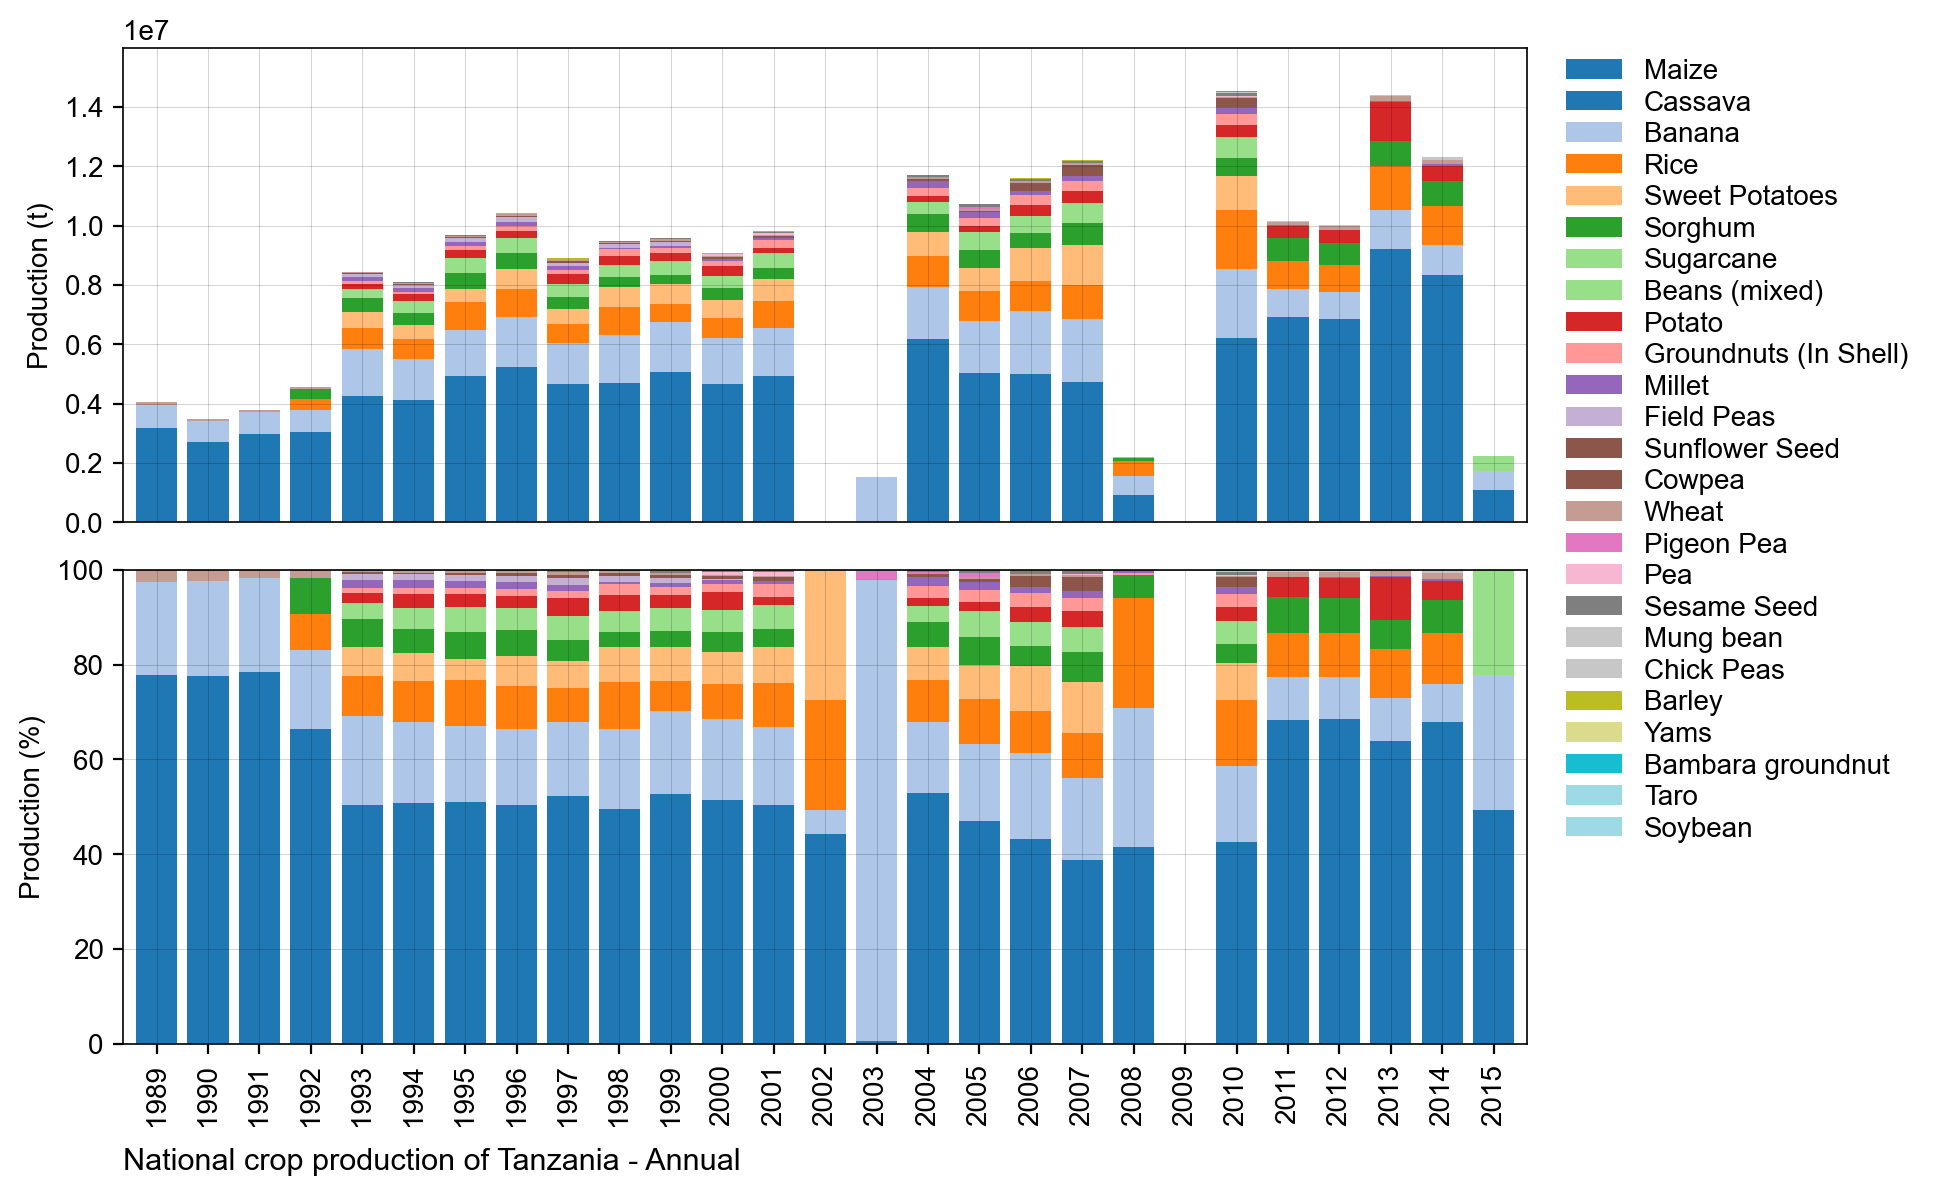

../figures/TZ_bar_natgrainprod_Annual.png is saved.


/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


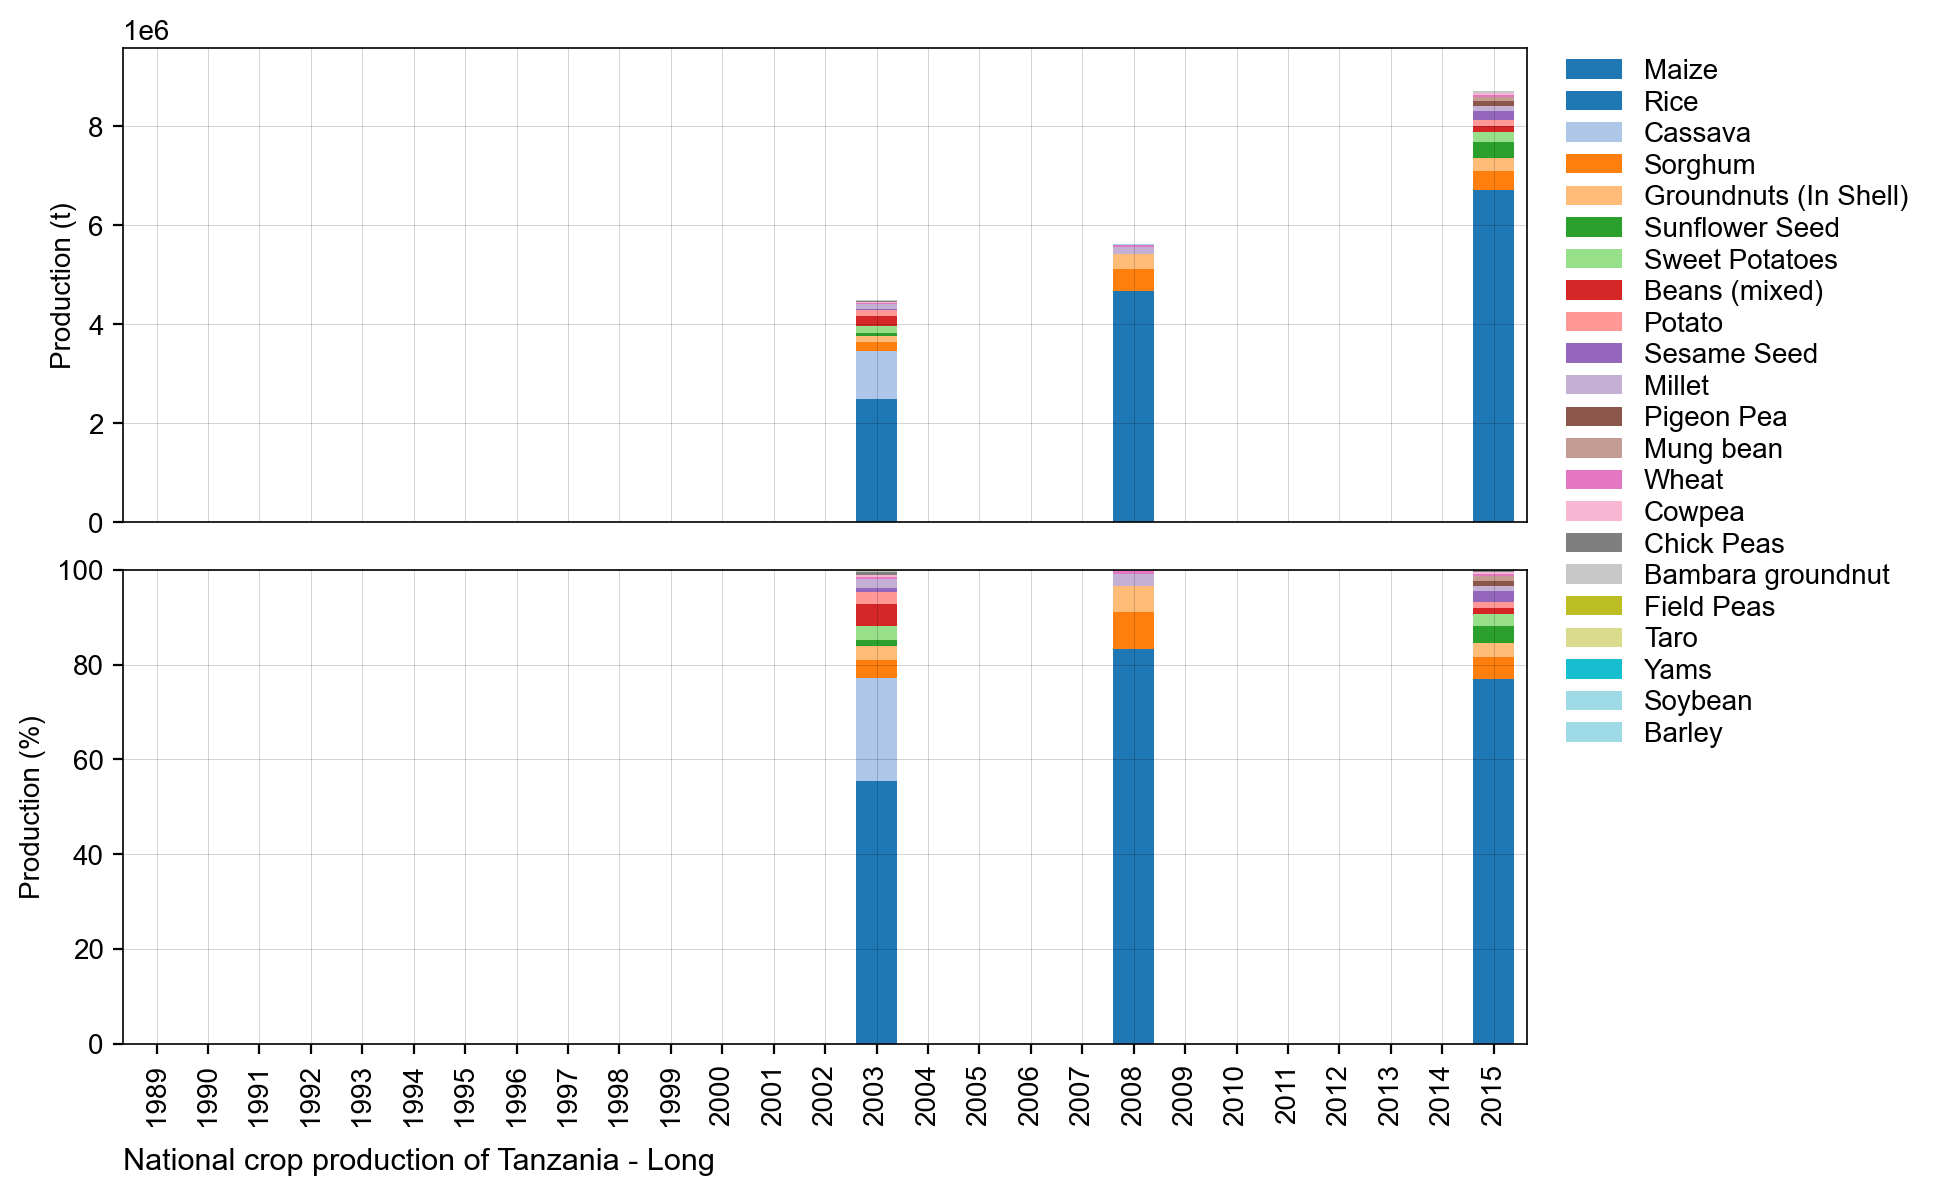

../figures/TZ_bar_natgrainprod_Long.png is saved.


/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


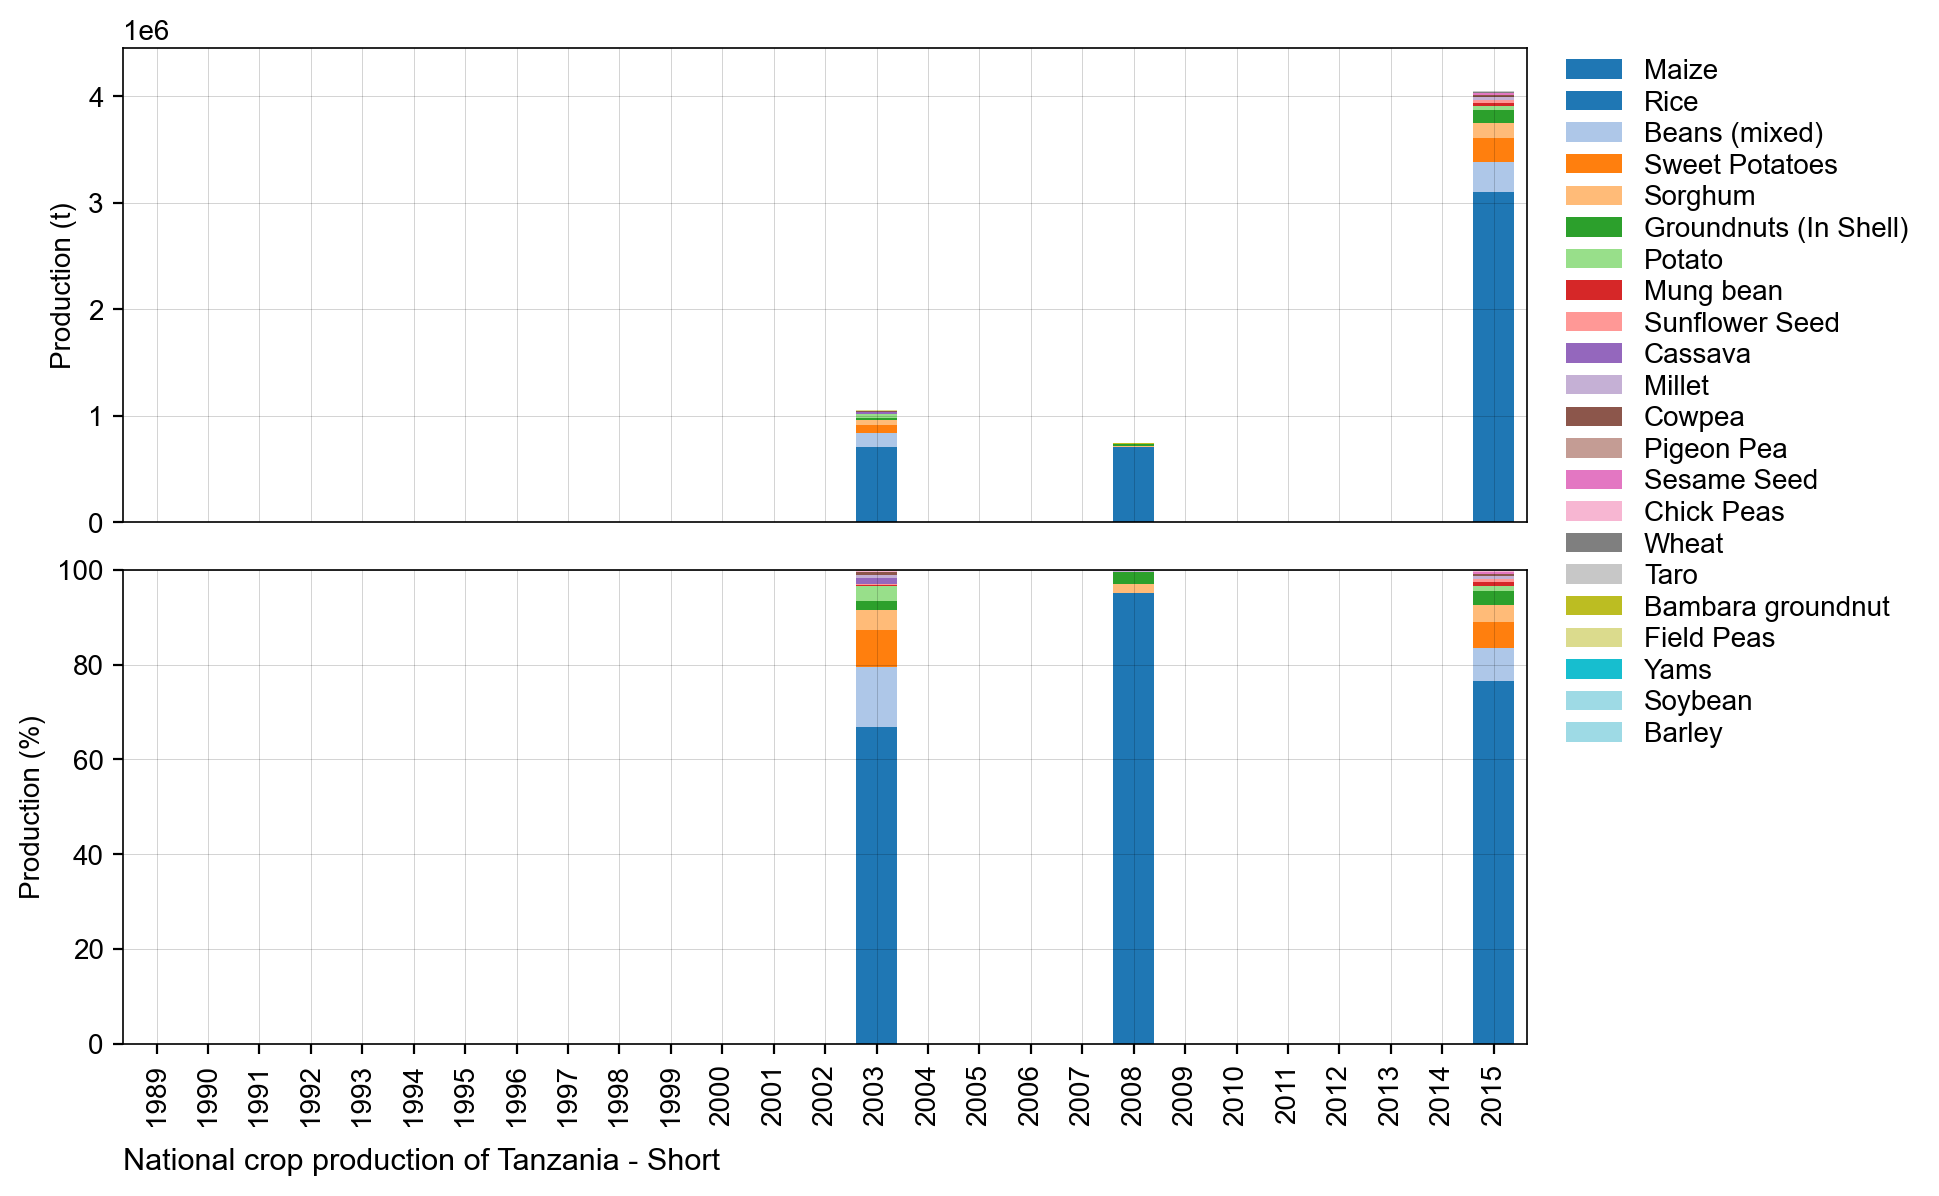

../figures/TZ_bar_natgrainprod_Short.png is saved.


/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


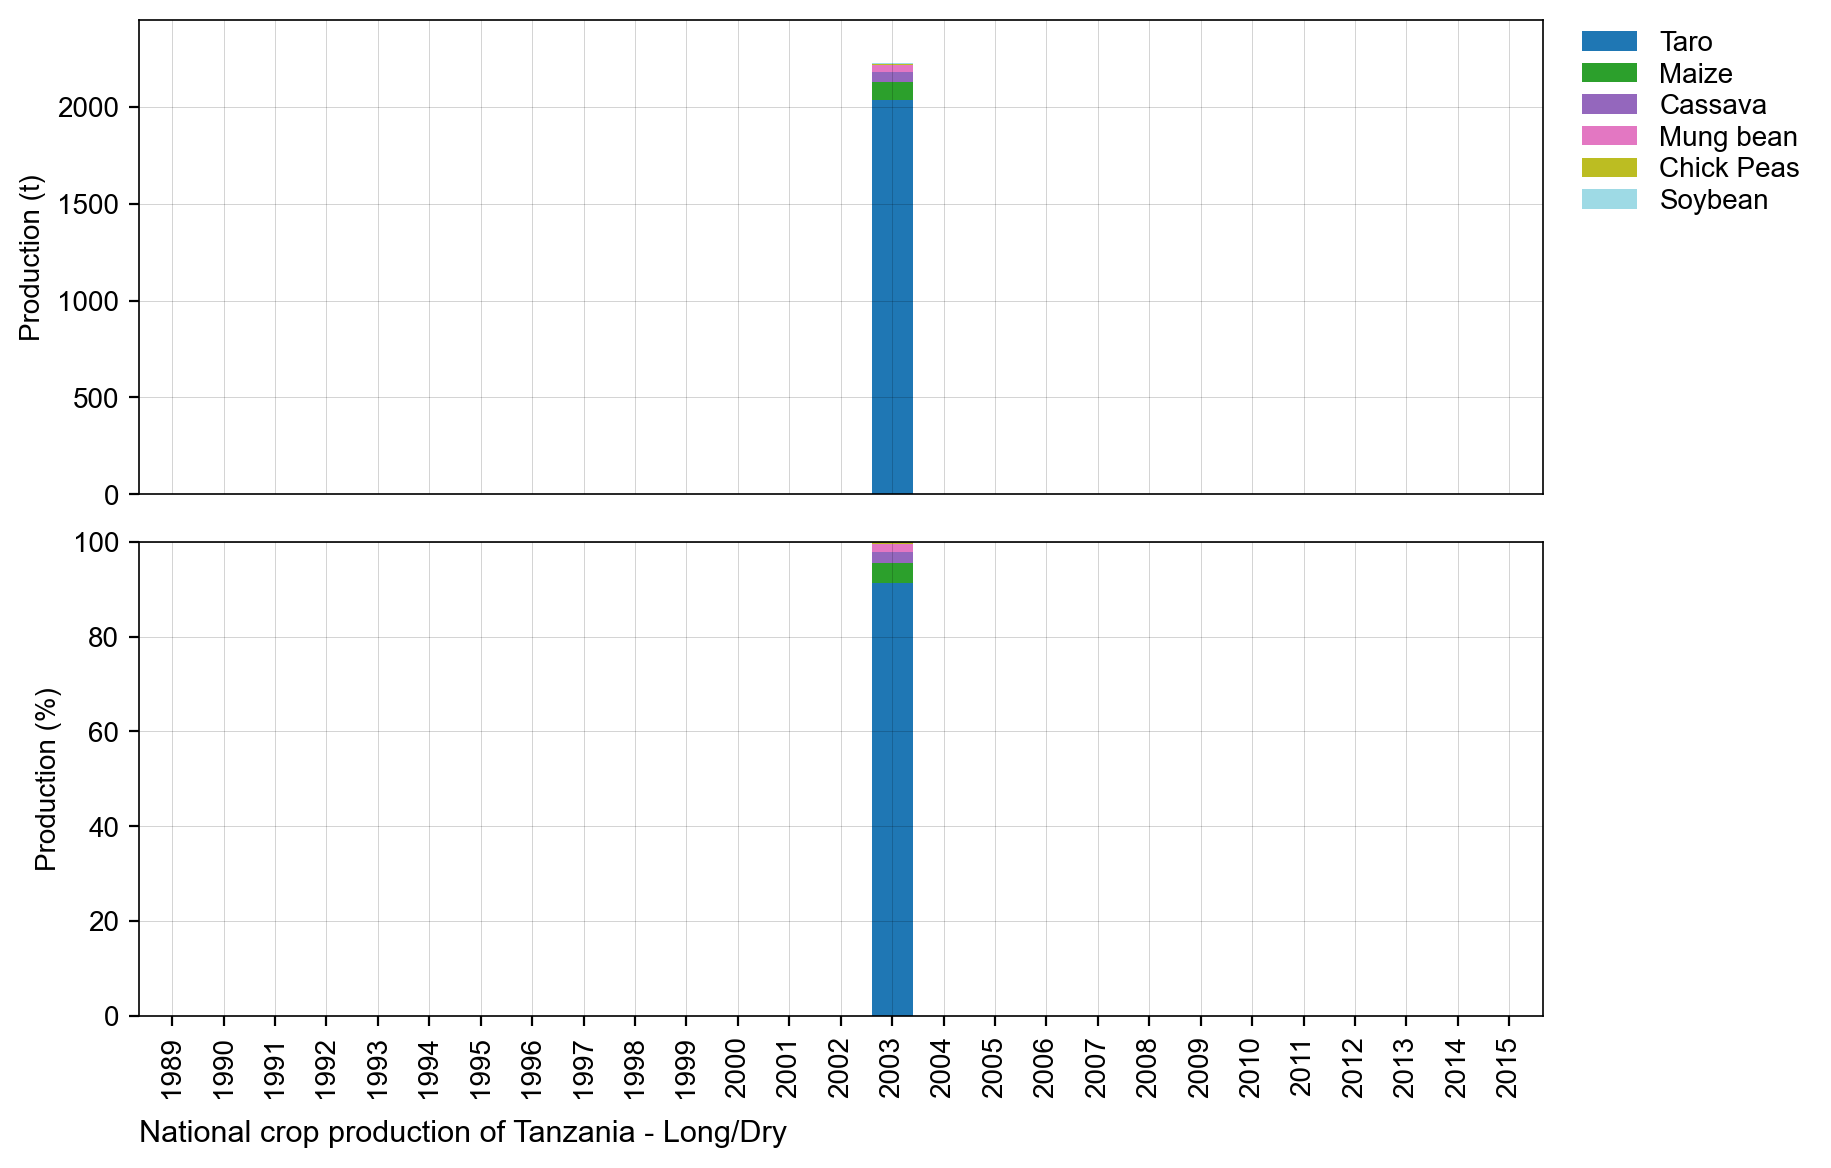

../figures/TZ_bar_natgrainprod_Long_and_Dry.png is saved.


In [11]:
# Bar chart of national grain production
country_iso, country_name = 'TZ', 'Tanzania'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Annual', 'Long', 'Short', "Long/Dry"]:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = "../figures/%s_bar_natgrainprod_%s.png" % (country_iso, season_name)
    if season_name == 'Long/Dry': 
        fn_save = "../figures/%s_bar_natgrainprod_%s.png" % (country_iso, "Long_and_Dry")
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

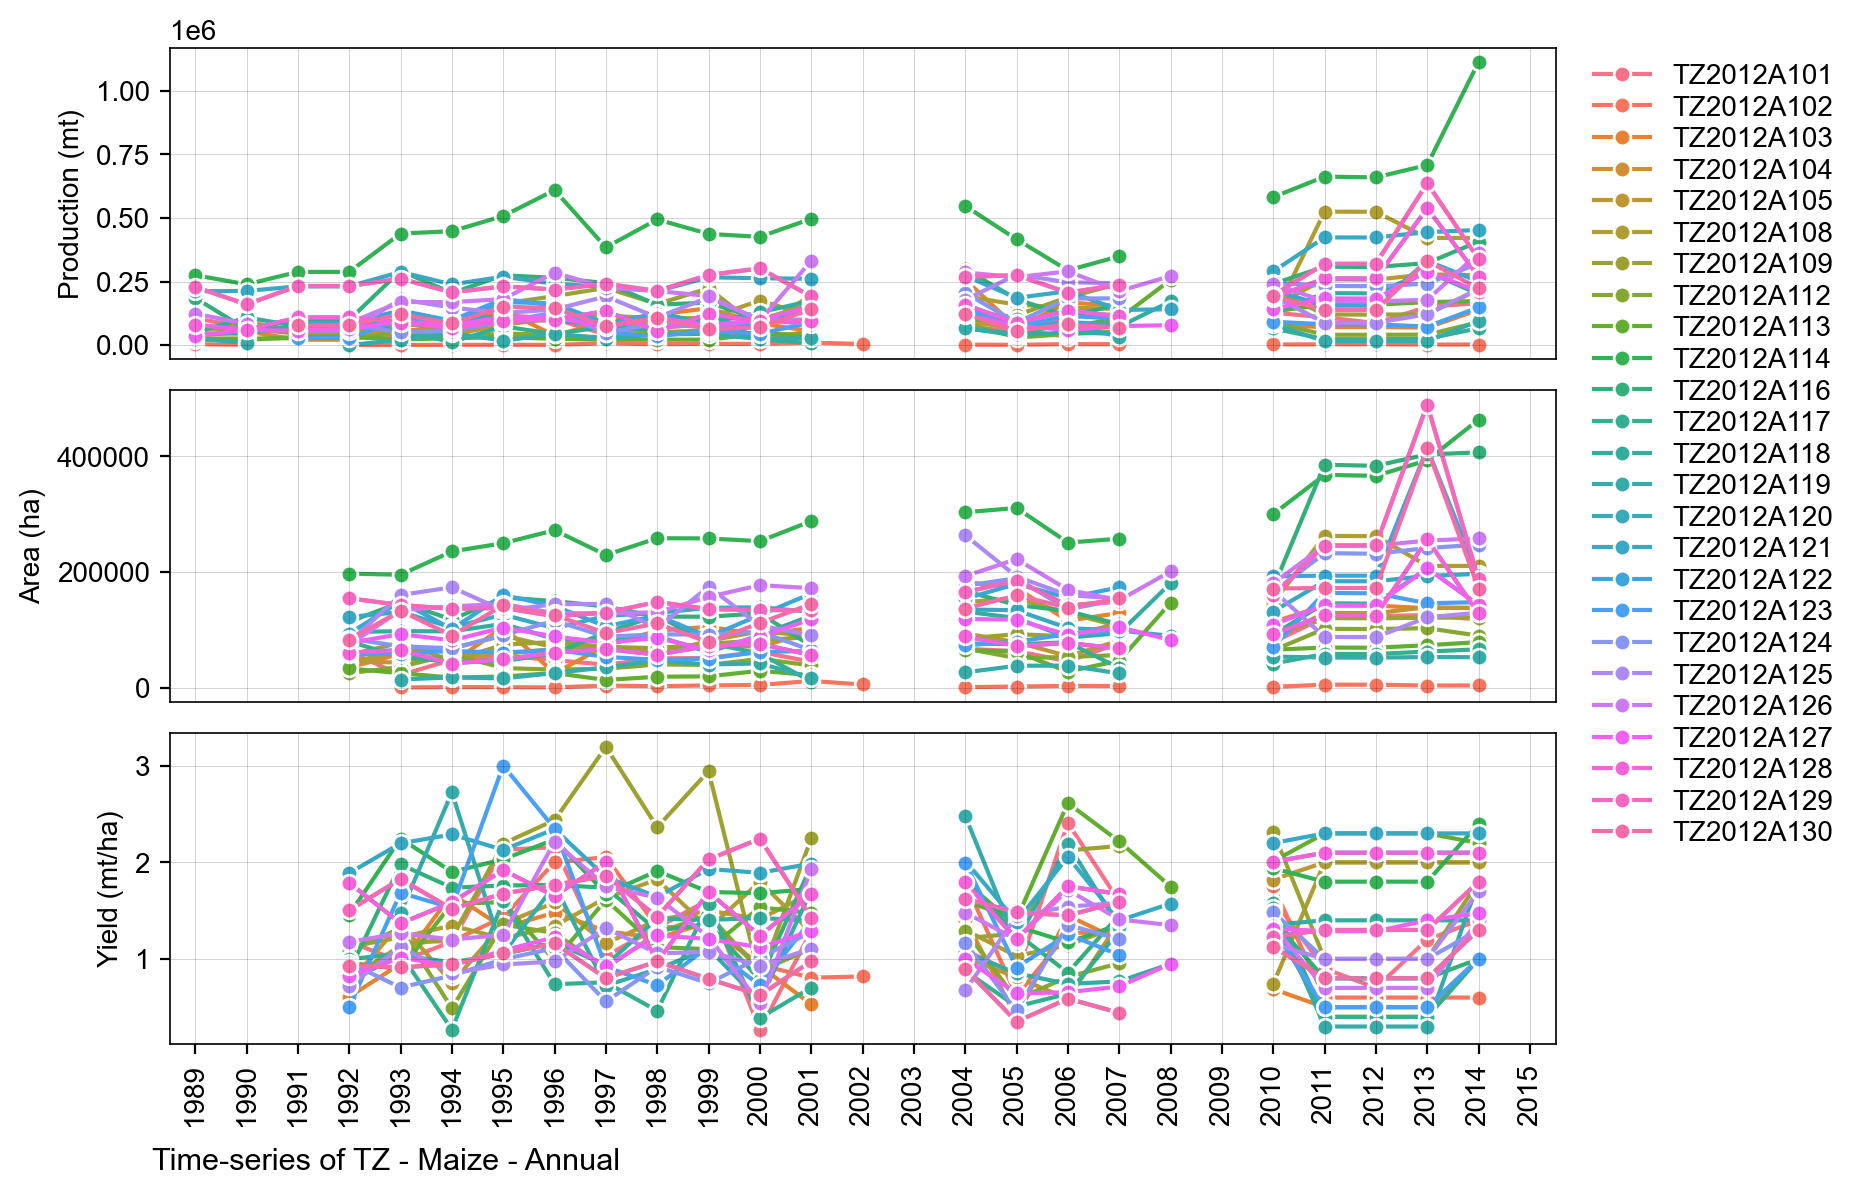

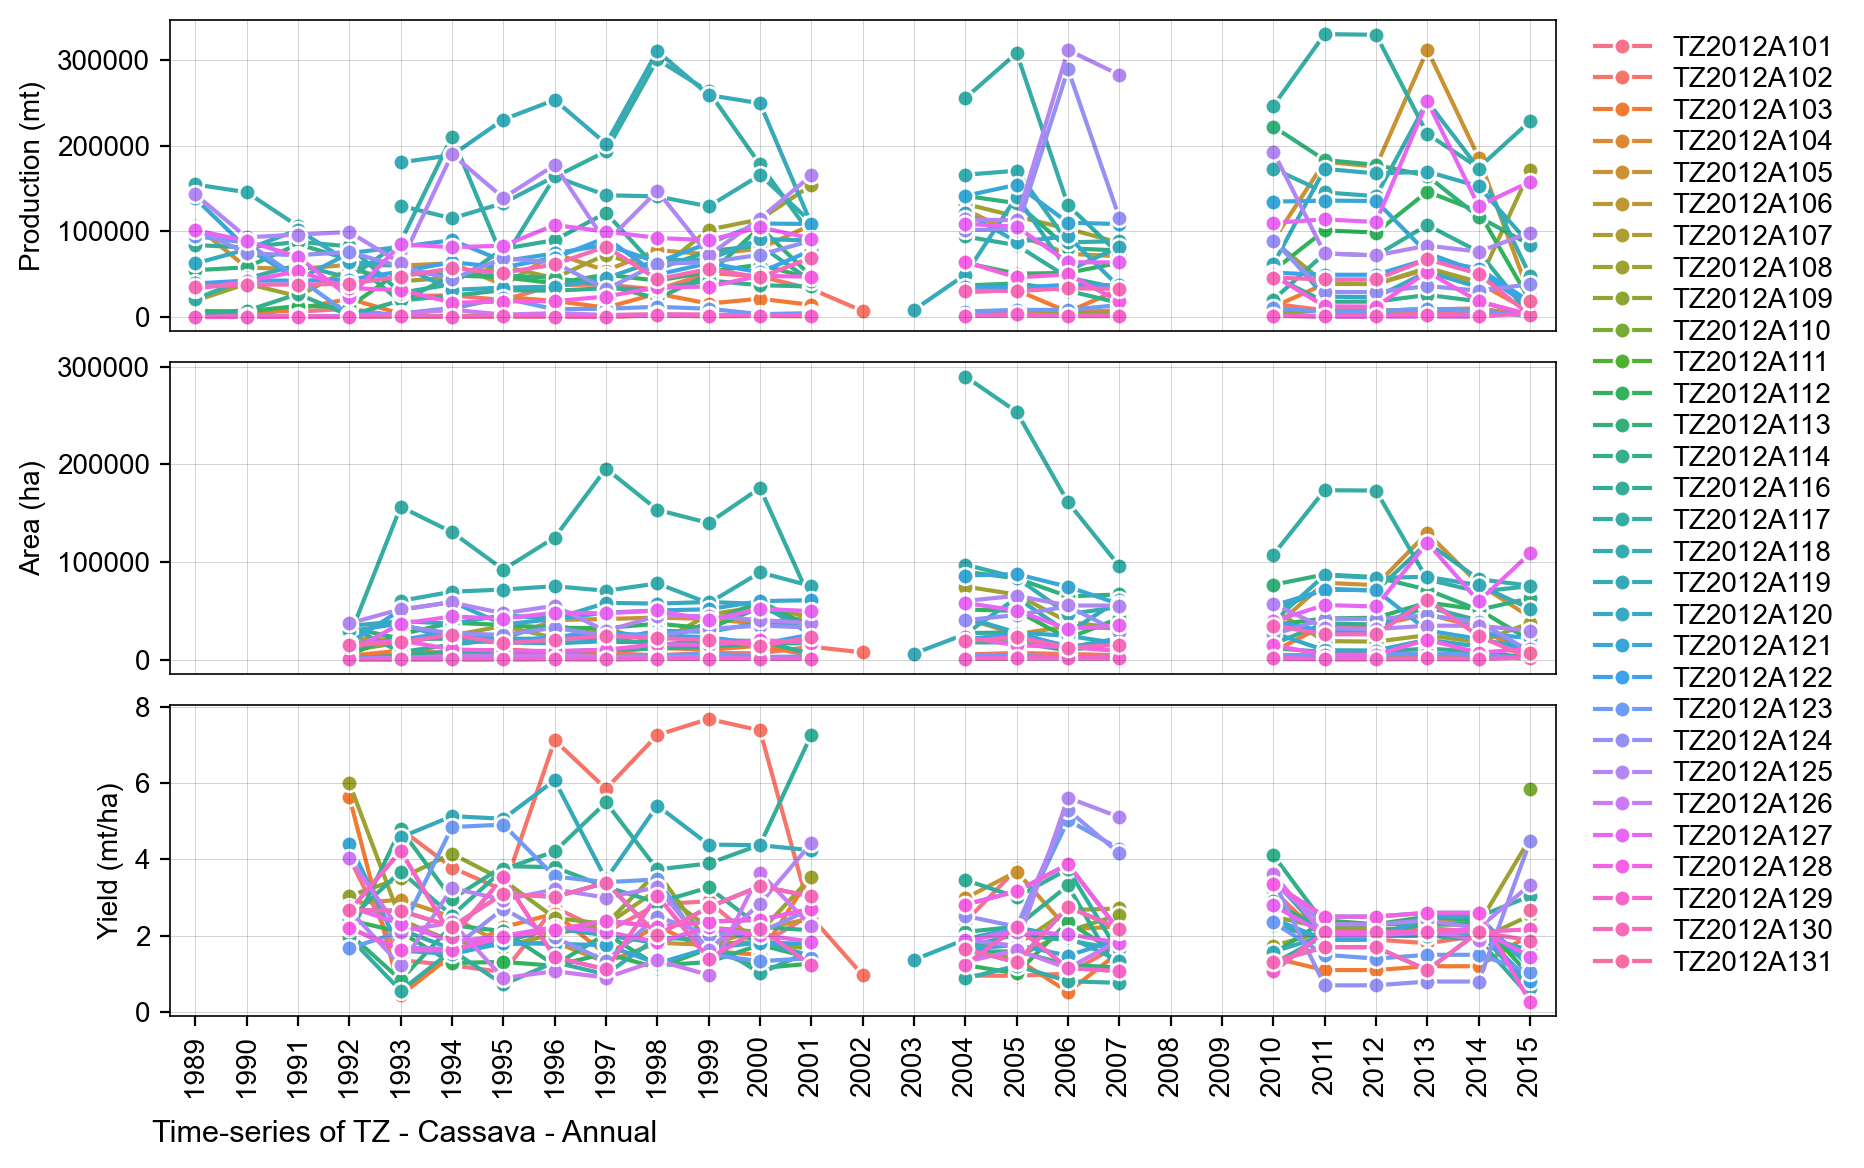

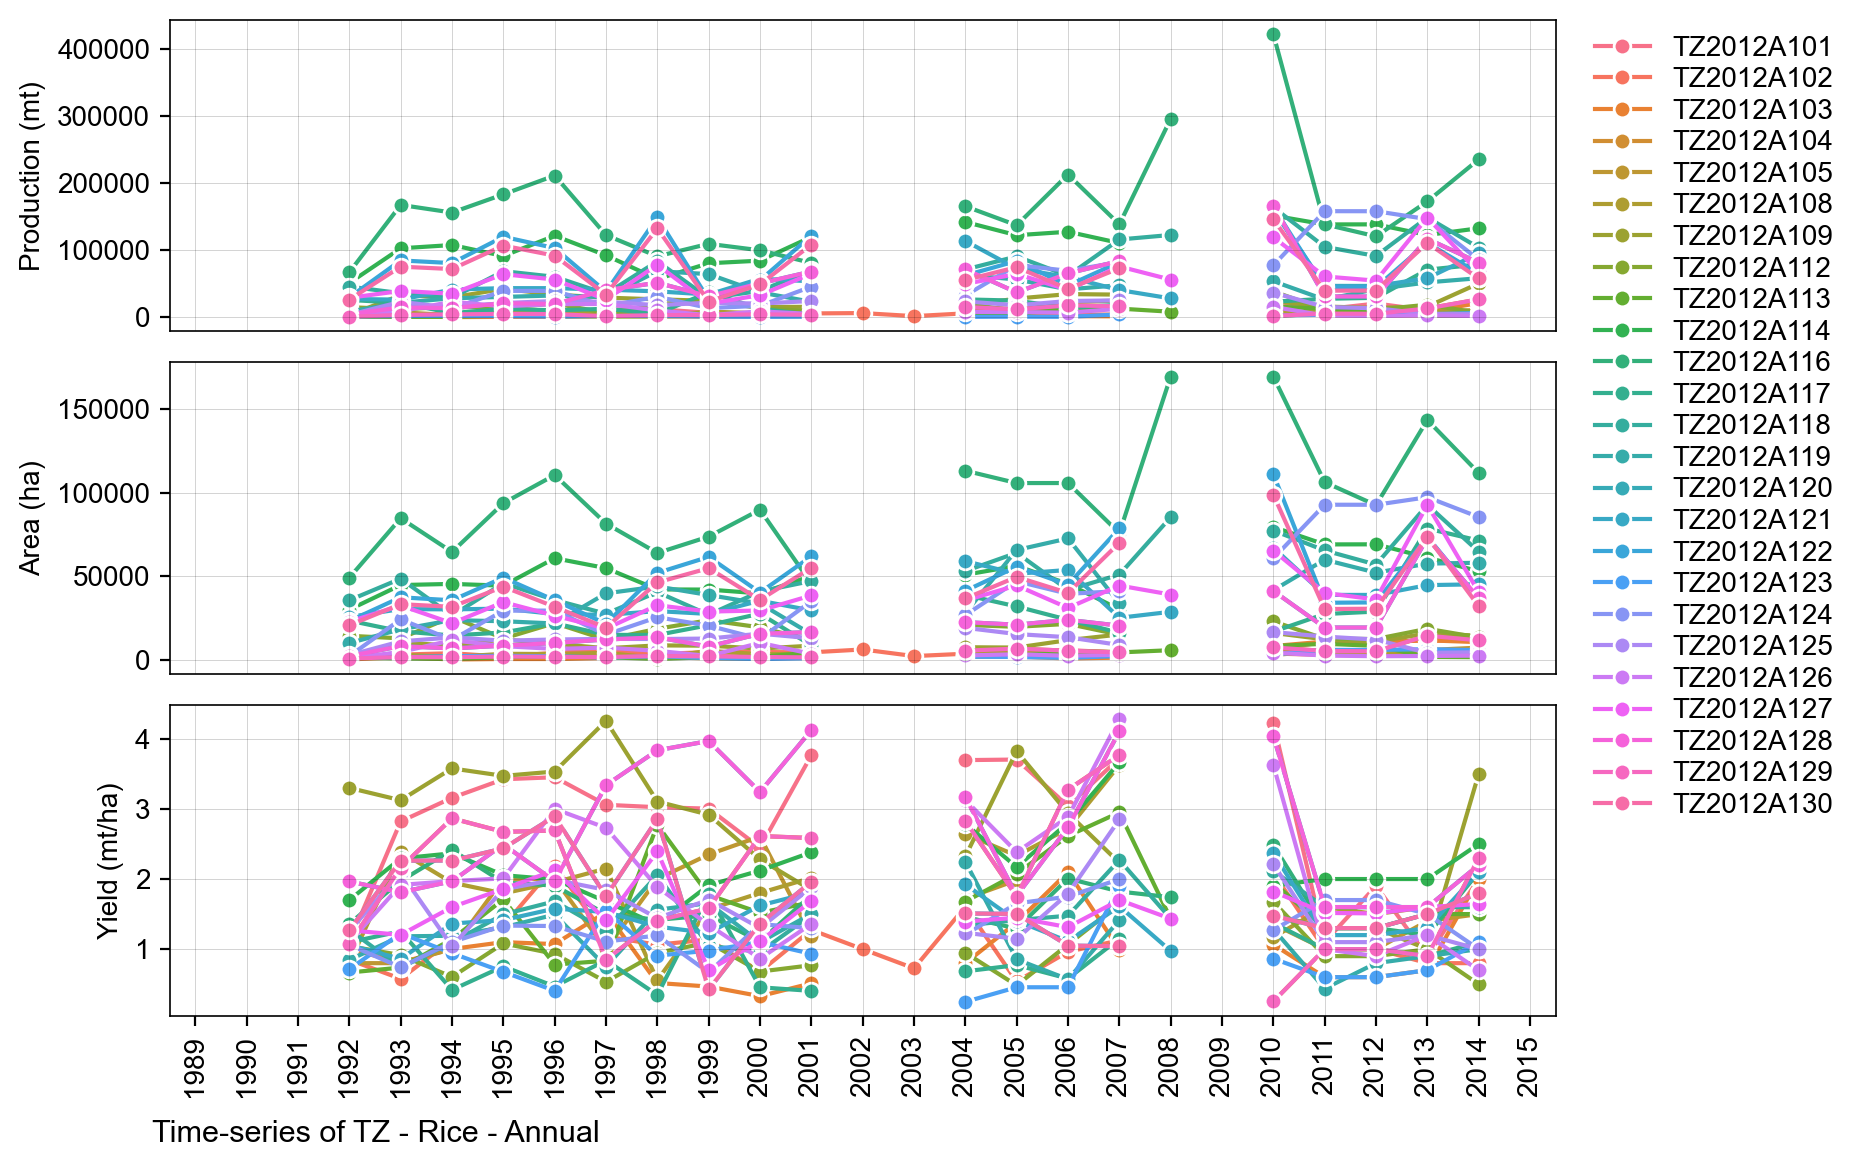

In [12]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name = 'TZ', 'Tanzania'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize', 'Annual'],
    ['Cassava', 'Annual'],
    ['Rice', 'Annual'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)